In [42]:
#!/usr/bin/env python
# coding: utf-8

# This script is used to compare ensemble outputs with NLDAS data
import argparse
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import xarray as xr
import datetime
from scipy.stats import mannwhitneyu
import multiprocessing as mp
import numpy.matlib
from tqdm import tqdm 

def read_stn_regr(out_forc_name_base, var, start_yr, end_yr):
    for yr in range(start_yr, end_yr+1):        
        
        file = os.path.join(out_forc_name_base + str(yr)+'0101_' + str(yr)+'1231' + '.nc')
        f=xr.open_dataset(file)
        time = f['time'][:]
        error = f.variables[var][:]
        
        if yr == start_yr:
            time_concat = time
            error_concat = error
        else:
            time_concat = np.concatenate((time_concat,time), axis=0) # (time)
            error_concat = np.concatenate((error_concat, error), axis=0) # (time,y,x)
            
    time_concat = pd.DatetimeIndex(time_concat)
        
    return time_concat, error_concat

def read_nldas_regr(out_forc_name_base, var, start_yr, end_yr):
    for yr in range(start_yr, end_yr+1):        
        
        file = os.path.join(out_forc_name_base + '.' + str(yr) + '.nc')
        f=xr.open_dataset(file)
        time = f['time'][:]
        error = f.variables[var][:]
        
        if yr == start_yr:
            time_concat = time
            error_concat = error
        else:
            time_concat = np.concatenate((time_concat,time), axis=0) # (time)
            error_concat = np.concatenate((error_concat, error), axis=0) # (time,y,x)
            
    time_concat = pd.DatetimeIndex(time_concat)
        
    return time_concat, error_concat

def mod_mannwhitneyu(x, y):
    # reference: https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
    # reference: https://www.statsdirect.com/help/basics/p_values.htm
    alpha1 = 0.05 # statistically significant
    alpha2 = 0.01
    alpha3 = 0.001 #statistically highly significant
    
    if all(np.isnan(x)) or all(np.isnan(y)):
#         print('all nan')
        p,judge1,judge2,judge3 = -999,-999,-999,-999
    else:
        
        stat, p = mannwhitneyu(x, y, use_continuity=True, alternative='two-sided')

        if p > alpha1:
            judge1,judge2,judge3 = 1,1,1 # Same distribution at alpha1,2,3 (fail to reject H0)
        elif p <= alpha1 and p > alpha2:
            judge1,judge2,judge3 = 0,1,1 # Different distribution at alpha1 (reject H0)'
        elif p <= alpha2 and p > alpha3:
            judge1,judge2,judge3 = 0,0,1 # Different distribution at alpha2 (reject H0)'
        elif p <= alpha3:
            judge1,judge2,judge3 = 0,0,0 # Different distribution at alpha3 (reject H0)'
    
    return p,judge1,judge2,judge3   

def MAE(x,y):
    if all(np.isnan(x)) or all(np.isnan(y)):
        mae = -999
    else:
        mae=np.nanmean(np.absolute(x-y)) 
    return mae

def crps_ensemble(x,y):
    
    if all(np.isnan(x)) or all(np.isnan(y)):
#         print('all nan')
        crps = -999
    else:
        
        #points
        p=np.linspace(0.9*np.minimum(np.amin(x), np.amin(y)),1.1*np.maximum(np.amax(x), np.amax(y)),num=50)
        data_num = len(x)

        #cumulative probability of p among x       
        a_obs=numpy.matlib.repmat(p,data_num,1)
        x.sort()
        b_obs=np.transpose(numpy.matlib.repmat(x,p.shape[0],1))
        F_obs=np.divide(np.sum(a_obs>b_obs,axis=0),data_num*1.0)

        #cumulative probability of p among y       
        a_sim=numpy.matlib.repmat(p,data_num,1)
        y.sort()
        b_sim=np.transpose(numpy.matlib.repmat(y,p.shape[0],1))
        F_sim=np.divide(np.sum(a_sim>b_sim,axis=0),data_num*1.0)

        #CRPS calculation: area between F and H
        dif=np.power(F_sim-F_obs,2)
        crps=np.trapz(dif,p)

    return crps

#======================================================================================================
def process_command_line():
    '''Parse the commandline'''
    parser = argparse.ArgumentParser(description='Script to do rank_sum test and calucalte CRPS between samples.')
    parser.add_argument('scenarios_id',
                        help='path of the HUC12 shapefile.')
    parser.add_argument('stn_var', 
                        help='HUC12 Id of the outlet flow gauge (in string). Obtained by viewing usgs_gauge_conus.shp and Catchment_UCOplus.shp.')
    parser.add_argument('nldas_var',
                        help='output file directory where basin HUC id will be written.')
    args = parser.parse_args()
    return(args)


# main
if __name__ == '__main__':

    # an example: python step25_rank_sum_test.py 0 'pcp_error' 'pcp_error_update'
    
    # process command line
    args = process_command_line()    
    scenarios_id=int(args.scenarios_id)
    stn_var=str(args.stn_var)
    nldas_var=str(args.nldas_var)
    print(scenarios_id,stn_var,nldas_var)
    
#     # FOR TEST
#     scenarios_id=8
#     stn_var='tmean_error' #'pcp_error'
#     nldas_var='tmean_error' #'pcp_error_update'

    # directories
    root_dir = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet'   
    stn_grid_file = os.path.join(root_dir,'data/nldas_topo/conus_ens_grid_eighth.nc')
    nldas_grid_file = os.path.join(root_dir,'data/nldas_topo/conus_ens_grid_eighth_deg_v1p1.nc')
    stn_regr_dir = os.path.join(root_dir,'data/stn_regr')

    result_dir = os.path.join(root_dir,'test_uniform_perturb')
    test_folders = [d for d in os.listdir(result_dir)]
    test_folders = sorted(test_folders)
    test_folder = test_folders[scenarios_id]
    nldas_regr_dir = os.path.join(root_dir,'test_uniform_perturb',test_folder,'gmet_regr')

    time_format = '%Y-%m-%d'
    start_yr = 2013
    end_yr = 2016
    plot_date_start = '2013-01-01'
    plot_date_end = '2016-12-31'
    plot_date_start_obj = datetime.datetime.strptime(plot_date_start, time_format)
    plot_date_end_obj = datetime.datetime.strptime(plot_date_end, time_format)

    output_dir=os.path.join(root_dir, 'scripts/step25_rank_sum_test')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    #======================================================================================================
    print('Read gridinfo mask')
    # get xy mask from gridinfo.nc
    f_stn_grid = xr.open_dataset(stn_grid_file)
    stn_mask_xy = f_stn_grid['mask'].values[:] # (y, x). 1 is valid. 0 is invalid.
    
    f_nldas_grid = xr.open_dataset(nldas_grid_file)
    nldas_mask_xy = f_nldas_grid['mask'].values[:] # (y, x). 1 is valid. 0 is invalid.
    
    # commonly available area
    mask_xy = (stn_mask_xy==0) | (nldas_mask_xy==0) 
    
    #======================================================================================================
    # read stn regression errors
    print('Read stn regression errors')
    # read
    output_namebase = os.path.join(stn_regr_dir, 'conus_regress_eighth_')
    stn_time_regr, stn_error = read_stn_regr(output_namebase, stn_var, start_yr, end_yr)

    # define plot mask for stn regr
    mask_stn_t = (stn_time_regr>=plot_date_start_obj) & (stn_time_regr<=plot_date_end_obj)
    stn_error = stn_error[mask_stn_t,:,:]    

    #======================================================================================================
    # read scenario regression results 
    print('Read nldas regression errors')
    # read
    output_namebase = os.path.join(nldas_regr_dir,'regress_ts')
    nldas_time_regr, nldas_error = read_nldas_regr(output_namebase, nldas_var, start_yr, end_yr)

    # define plot mask for nldas regr
    mask_nldas_t = (nldas_time_regr>=plot_date_start_obj) & (nldas_time_regr<=plot_date_end_obj)
    nldas_error = nldas_error[mask_nldas_t,:,:]    

    #======================================================================================================
    # rank_sum test and CRPS  
    print('Rank_sum test')

    stn_error[:,mask_xy] = np.nan # fill_value of stn_regr is zero.
    nldas_error[:,mask_xy] = np.nan 

    (ny,nx) = np.shape(mask_xy)
    test = np.zeros((ny,nx,4)) # three significance/alpha levels
    crps = np.zeros((ny,nx))
    mae = np.zeros((ny,nx))
   
    # step 1: Init multiprocessing.Pool()
    pool = mp.Pool(mp.cpu_count())

    # step 2: `pool.apply`     
    for i in tqdm(range(ny)):
        test[i,:,:] = [pool.apply(mod_mannwhitneyu, args=(stn_error[:,i,j], nldas_error[:,i,j])) for j in range(nx)]
        crps[i,:] = [pool.apply(crps_ensemble, args=(stn_error[:,i,j], nldas_error[:,i,j])) for j in range(nx)]
        mae[i,:] = [pool.apply(MAE, args=(stn_error[:,i,j], nldas_error[:,i,j])) for j in range(nx)]

    # step 3: Don't forget to close
    pool.close()   
    
    #======================================================================================================
    # Save  
    print('Save')
    # save results
    output_file_namebase = test_folder+'_'+nldas_var

    # p value
    ofile = os.path.join(output_dir, output_file_namebase+'_HypoTest_p.txt')
    np.savetxt(ofile,test[:,:,0],fmt='%f',delimiter=',', 
               header='Rank_sum test (p-values).')
    
    # hypothesis test judge
    alphas = ['005', '001', '0001']
    for i in range(len(alphas)):
        alpha = alphas[i]
        ofile = os.path.join(output_dir, output_file_namebase+'_HypoTest_'+alpha+'.txt')
        np.savetxt(ofile,test[:,:,i+1],fmt='%d',delimiter=',', 
                   header='Rank_sum test (alpha = '+alpha+'. 1 is different, 0 is the same dist.).')
    # crps
    ofile = os.path.join(output_dir, output_file_namebase+'_CRPS.txt')
    np.savetxt(ofile,crps,fmt='%f',delimiter=',', 
               header='CRPS between stn_regr and nldas_regr uncertainties at each grid.')

    print('Done')


Rank_sum test


100%|██████████| 224/224 [04:20<00:00,  1.16s/it]


Save
Done


In [52]:
crps = np.zeros((ny,nx))
# step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# step 2: `pool.apply`     
for i in tqdm(range(ny)):
    crps[i,:] = [pool.apply(crps_ensemble, args=(stn_error[:,i,j], nldas_error[:,i,j])) for j in range(nx)]

# step 3: Don't forget to close
pool.close()   

ofile = os.path.join(output_dir, output_file_namebase+'_CRPS.txt')
np.savetxt(ofile,crps,fmt='%f',delimiter=',', 
           header='CRPS between stn_regr and nldas_regr uncertainties at each grid.')


100%|██████████| 224/224 [02:55<00:00,  1.28it/s]


In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt

root_dir = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet'   
output_dir=os.path.join(root_dir, 'scripts/step25_rank_sum_test')
test_folder = '00818grids'
nldas_var = 'tmean_error_2'
output_file_namebase = test_folder+'_'+nldas_var

ofile = os.path.join(output_dir, output_file_namebase+'_HypoTest_p.txt')
p = np.loadtxt(ofile,delimiter=',')
# p=np.where(data==-999,np.nan,data)

ofile = os.path.join(output_dir, output_file_namebase+'_HypoTest_005.txt')
judge = np.loadtxt(ofile,delimiter=',')
# judge=np.where(data==-999,np.nan,data)

ofile = os.path.join(output_dir, output_file_namebase+'_MAE.txt')
mae = np.loadtxt(ofile,delimiter=',')
# mae=np.where(data==-999,np.nan,data)

print('Done')


Done


In [8]:
np.where(judge==0)

(array([  0,   0,   0, ..., 223, 223, 223]),
 array([101, 102, 103, ..., 461, 462, 463]))

In [9]:
i = 1
j = 103
judge[i,j],p[i,j],mae[i,j]

(nan, nan, nan)

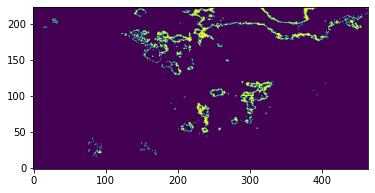

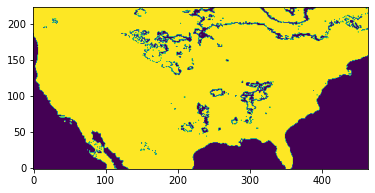

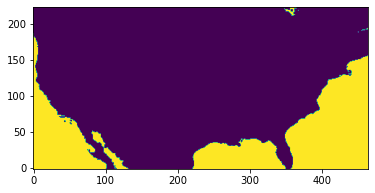

In [17]:
import matplotlib.pyplot as plt
plt.imshow((judge==1),origin='lower')
plt.show()
plt.imshow((judge==0),origin='lower')
plt.show()
plt.imshow((judge==-999),origin='lower')
plt.show()

In [45]:
crps

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])